### Парсинг данных и создание датафрейма

In [13]:
def procents(d):
    l = len(d)
    res = []
    for name in set(d['name']):
        count = len(d[d['name'] == name])
        res.append((name, count, count/l*100))
    return pd.DataFrame(res, columns=['name', 'count', 'percent'])

In [18]:
def dose_weights(d):
    l = len(d)
    res = []
    total_dose = sum(d['dE'])
    for name in set(d['name']):
        particle_filt = d[d['name'] == name]
        dose = sum(particle_filt['dE'])
        res.append((name, dose, dose/total_dose*100))
    return pd.DataFrame(res, columns=['name', 'dose', 'dose_percent'])

In [69]:
def get_z_dose_bins(d, bins=100):
    borders = np.linspace(-20, 20, bins)
    bins = []
    for i in range(len(borders[:-1])):
        dd = d[d['z'] > borders[i]]
        bin_data = dd[dd['z'] < borders[i+1]]
        bins.append(sum(bin_data['dE']))
    return np.array(borders[:-1])+20, np.array(bins)

In [75]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
runN = "*" # If take all runs set runN = "*"
paths = glob.glob(f"build/Run{runN}_nt_ParticleData_t*.csv") #accel_data_secondary
assert len(paths) == 20

In [4]:
with open(paths[0], 'r') as f:
    print(f"Headers from file: {paths[0]}")

    hlines = []
    while True:
        line = f.readline()
        if len(line) == 0 or line[0] != '#':
            break
        hlines.append(line)
    title = hlines[1].replace('#title ', '')[:-1]
    sep = chr(int(hlines[2].replace('#separator ', '')[:-1]))
    vsc_sep = chr(int(hlines[3].replace('#vector_separator ', '')[:-1]))
    columns = [' '.join(l.split(' ')[2:])[:-1] for l in hlines[4:]]
    meta_len = len(hlines)
    # print(f'Metarows: {meta_len}\nColumns: {columns}')

Headers from file: build/Run0_nt_ParticleData_t8.csv


In [5]:
pnames = {'annihil':'Аннигиляция','compt':'Комптон-эффект','conv':'Обратная аннигиляция',
          'eBrem':'Тормозное излучение','eIoni':'Ионизационные потери','hadElastic':'?',
          'phot':'Фотоэффект','photonNuclear':'?'}

In [6]:
data = pd.DataFrame()
for path in paths[:10]:
    item = pd.read_csv(path, skiprows=meta_len, names=columns)
    data = pd.concat([data, item], ignore_index=True)

In [7]:
len(data)

13977862

In [8]:
data

,particle_name,creator_process,parentID,energy,z,dE
0,e-,user,0,0.544467,-20.0000,0.000097
1,e-,user,0,0.544359,-19.9999,0.000108
2,e-,user,0,0.544172,-19.9998,0.000187
3,e-,user,0,0.543680,-19.9996,0.000492
4,e-,user,0,0.543083,-19.9993,0.000597
...,...,...,...,...,...,...
13977857,e-,user,0,0.069227,-19.9227,0.013475
13977858,e-,user,0,0.049022,-19.9209,0.020205
13977859,e-,user,0,0.025893,-19.9197,0.023130
13977860,e-,user,0,0.003790,-19.9185,0.022103


## "Первичные" ускорительные частицы

In [12]:
primary = data[data['creator_process'] == 'user']
len(primary)

7555809

In [14]:
procents(primary)

,name,count,percent
0,e-,6392013,84.597334
1,gamma,996393,13.187112
2,geantino,167403,2.215554


In [24]:
print('Суммарная доза от первичных частиц:', sum(dose_weights(primary)['dose']))
dose_weights(primary)

Суммарная доза от первичных частиц: 314826.1191056307


,name,dose,dose_percent
0,e-,314715.427436,99.96484
1,gamma,110.691670,0.03516
2,geantino,0.000000,0.00000


## Вторичные частицы в фантоме

In [15]:
secondary = data[data['creator_process'] != 'user']
len(secondary)

6422053

In [26]:
print('Суммарная доза от вторичных частиц:', sum(dose_weights(secondary)['dose']))
dose_weights(secondary)

Суммарная доза от вторичных частиц: 238370.40745660441


,name,dose,dose_percent
0,alpha,51.365636,2.154866e-02
1,C12,17.325490,7.268306e-03
2,N15,1.620386,6.797765e-04
3,O16,0.171638,7.200492e-05
4,gamma,34.834543,1.461362e-02
5,proton,20.460551,8.583511e-03
6,O15,0.183168,7.684175e-05
7,neutron,0.154811,6.494567e-05
8,e-,228413.363883,9.582287e+01
9,O18,0.000043,1.809711e-08


## Доза от глубины

**Доза от первичных и вторичных частиц**

In [78]:
borders1, bins1 = get_z_dose_bins(data)
borders2, bins2 = get_z_dose_bins(primary)
borders3, bins3 = get_z_dose_bins(secondary)

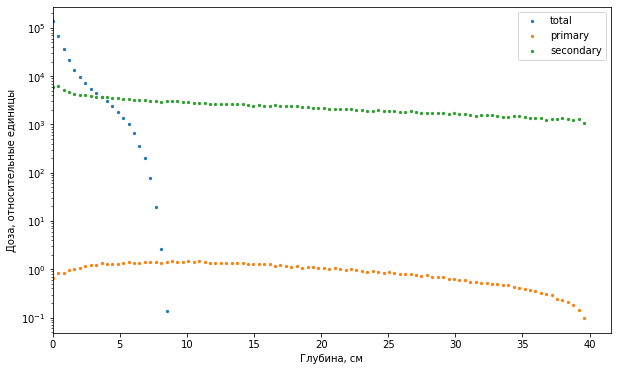

In [82]:
plt.scatter(borders1, bins1, s=5, label='total')
plt.scatter(borders2, bins2, s=5, label='primary')
plt.scatter(borders3, bins3, s=5, label='secondary')
plt.xlim([0, plt.xlim()[1]])
# plt.ylim([0, plt.ylim()[1]])
plt.yscale('log')
plt.ylabel('Доза, относительные единицы')
plt.xlabel('Глубина, см')
plt.legend()
plt.show()

**Доза от первичных частиц**

In [80]:
borders1, bins1 = get_z_dose_bins(primary[primary['particle_name'] == 'e-'])
borders2, bins2 = get_z_dose_bins(primary[primary['particle_name'] == 'gamma'])

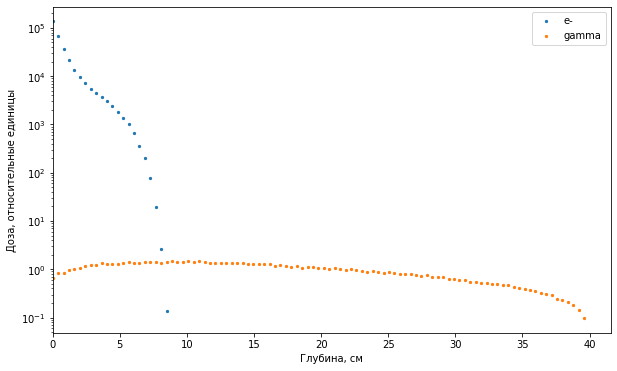

In [83]:
plt.scatter(borders1, bins1, s=5, label='e-')
plt.scatter(borders2, bins2, s=5, label='gamma')
plt.xlim([0, plt.xlim()[1]])
# plt.ylim([0, plt.ylim()[1]])
plt.yscale('log')
plt.ylabel('Доза, относительные единицы')
plt.xlabel('Глубина, см')
plt.legend()
plt.show()

**Доза от вторичных частиц**

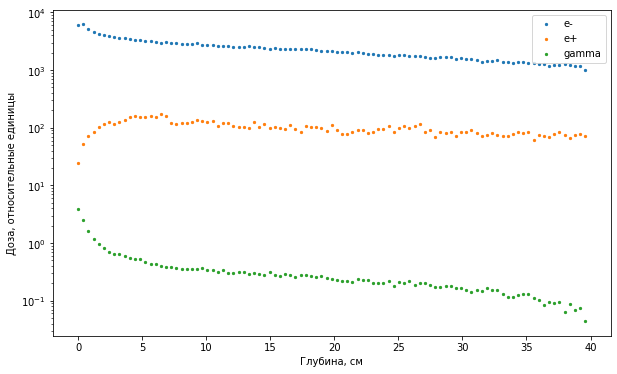

In [84]:
for name in ['e-','e+', 'gamma']:
    borders, bins = get_z_dose_bins(secondary[secondary['particle_name'] == name])
    plt.scatter(borders, bins, s=5, label=name)
plt.yscale('log')
plt.ylabel('Доза, относительные единицы')
plt.xlabel('Глубина, см')
plt.legend()
plt.show()

## Распределение по энергиям

In [87]:
def get_energy_count_bins(d, bins=100):
    n, e = np.histogram(d['energy'], bins)
    return e[:-1], n

**Энергия вторичных частиц**

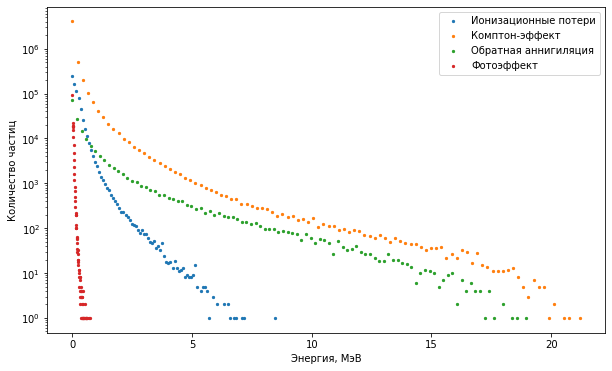

In [88]:
for process in ['eIoni', 'compt', 'conv', 'phot']:
    energys, counts = get_energy_count_bins(secondary[secondary['creator_process'] == process])
    plt.scatter(energys, counts, s=5, label=pnames[process])

# for process in ['eIoni', 'compt', 'conv', 'phot']:
#     proc_data = filt[filt['creator_process'] == process]
#     # n, e, _ = plt.hist(proc_data['energy'], bins=100)
#     n, e = np.histogram(proc_data['energy'], bins=100)
#     plt.plot(e[:-1], n, label=pnames[process]) # 
plt.legend()
# plt.ylim([10, 10**8])
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()

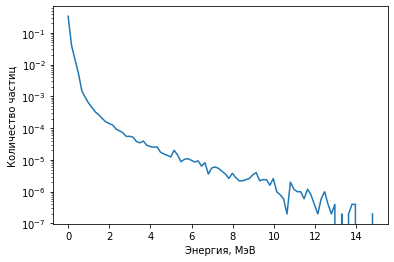

In [13]:
filt = data[data['name'] == 'gamma']
n, e = np.histogram(filt['energy'], bins=100)
n, e = n[:-10], e[:-11]
plt.plot(e, n/(0.5*10**7))
#plt.xlim([0, 20])
#plt.legend()
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()